In [8]:
from transformers import BartTokenizerFast
from functools import partial
from data_utils_word_rank import to_cuda, collate_mp_brio, BrioDataset
from torch.utils.data import Dataset,DataLoader
from transformers.models.bart.configuration_bart import BartConfig
from model import BRIO
import torch
import torch.nn as nn
import numpy as np

In [71]:

# cnndm
model_name = "/mnt/nas4/m11115088/WordRank/CNN_Model/GPT_final_chpt_bart"
tok = BartTokenizerFast.from_pretrained(model_name, verbose=False)
collate_fn = partial(collate_mp_brio, pad_token_id=tok.pad_token_id, is_test=True)
# dataset=load_dataset('cnn_dailymail',version="3.0.0")
# train_set=BrioDataset(dataset['train'], "facebook/bart-large-cnn",total_len=1024, max_len=120)

# train_set = BrioDataset(f"/work/u5516210/BRIO/cnndm_cased/test", "facebook/bart-large-cnn",is_sorted=False, max_len=120, max_num=0, is_test=True,total_len=1024)
# train_set = BrioDataset(f"cnndm/diverse/test", "facebook/bart-large-cnn",is_sorted=False, max_len=120, max_num=0, is_test=True,total_len=1024)
train_set = BrioDataset(f"test", model_name,dataset="cnndm",is_sorted=False, max_len=256, max_num=0, is_test=True,total_len=1024)

dataloader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=5, collate_fn=collate_fn)
for batch in dataloader:
    if batch['src_input_ids'].size(1)<200:
        batcha = batch
        break
# batcha["keyword_position"]

In [72]:
batcha['src_input_ids']

tensor([[    0,  1640, 16256,    43,  2709,     5,    78,    86,    11,   799,
           107,     6,    10,  1012,  7875,  1835,     7,   608,    99,    37,
           473,   275,     4, 17657,  3277,   174,     7,    22, 19807,    15,
           159,  2901,    15,     5,   587,   112,  5403,     9,    22,   133,
          3655,  1534,  5143,   113, 13590,    45,  1482,  8238, 13179,    53,
           277,  2950,   652,    11,  1427,     9,     5,  7069,     4,  2978,
             6,    89,    21,  3045, 21998,     6,    54,  4457,     5,  1012,
           177,   311,    13,  1718,   107,   137,  8296,   159,    11,  3010,
             4,  7817,  2292,  1506,    23,  8301,     6, 21998,  7521,     5,
            78,   425,    12,  5521, 29905,   177,     9,     5,   311,     6,
             5,  4187,    22,   574, 19873,  7732,    60,   137,  3408,  5162,
          5941,    81,     7, 13179,     6,    54,  1550,    62,     4,  2285,
           145,   409,    31,     5,   311,    13,  

In [98]:

class myModel(nn.Module):
    def __init__(self,model=None):
        super().__init__()
        # self.model=BRIO("facebook/bart-large-cnn",1,False)
        self.encoder = model.get_encoder()
        # self.energy_net = BartClassificationHead(
        #         1024, 1024, 1, 0.0,
        # )
    def forward(self, src):
        input_mask = src["src_input_ids"] != 1
        output = self.encoder(
            input_ids=src["src_input_ids"],
            # segment_ids=src["segment_id"],
            attention_mask=input_mask,
            src_word_position = src["src_input_ids"]
        )

        # word_energy = self.energy_net(output.last_hidden_state).squeeze(2)

        return output
config = BartConfig.from_pretrained(model_name)
model=BRIO(model_name,1,config,False)
# model=BRIO("facebook/bart-large-xsum",1,False)
# model.load_state_dict(torch.load("/mnt/nas5/m11115088/BRIO_word_rank/cache/23-03-19-18-48-1679222891/model_cur4.bin", map_location='cpu'))
# model.load_state_dict(torch.load("/mnt/nas5/m11115088/BRIO_word_rank/cache/23-03-25-21-25-1679750700version_1/model_cur2.bin", map_location='cpu'))
# model.load_state_dict(torch.load("/mnt/nas5/m11115088/BRIO_word_rank/cache/seg_in_word_rank/model_cur1.bin", map_location="cuda:3"))
# model.load_state_dict(torch.load("/work/u5516210/BRIO/cache/ctrlsum_word_rank/model_cur1.bin", map_location="cpu"))

# model.load_state_dict(torch.load("cache/07-11-16-08-1720685307_BART_SCAN_10_new_c_again/model_generation.bin", map_location="cpu"),strict=False)
model.load_state_dict(torch.load("cache/07-11-16-09-1720685361_BART_cnndm_gpt_c3/model_generation.bin", map_location="cpu"),strict=False)

# model.load_state_dict(torch.load("cache/transformer_wordrank_soft/model_cur1.bin", map_location="cpu"),strict=False)
device = "cuda:2"
model = myModel(model)
# model.load_state_dict(torch.load("/mnt/nas5/m11115088/BRIO_word_rank/cache/pretrained_encoder_0.bin", map_location='cpu'),strict=False)
# model=model
model.to(device)
model.eval()
# model.train()
# d_optimizer = optim.Adam(model.parameters(),lr=0.01)
# model.state_dict()
def to_cuda(batch, gpuid):
    for n in batch:
        if n != "data":
            batch[n] = batch[n].to(gpuid)


In [99]:
%matplotlib inline
to_cuda(batcha, device)
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="TaipeiSansTCBeta-Regular.ttf")  # 替換成你的字體文件路徑
ext_data = model(batcha)
# engy = torch.linalg.norm(ext_data["last_hidden_state"], ord=2, dim=2)


In [100]:
w_y=[]
word_n=[]
seg=[]
for i in range(torch.max(batcha["src_word_position"]).item()):
    position = torch.where(batcha["src_word_position"]==i, True, False)
    # print(batcha["segment_id"][position],tok.decode(batcha["src_input_ids"][position]),batcha["src_word_position"][position])
    # print(torch.unique(batcha["segment_id"][position]))
    # seg.append(torch.unique(batcha["segment_ids"][position]).item())

    # print(seg)
    # print(ext_data["word_energy"][position]/position.sum(-1))
    word_n.append(tok.decode(batcha["src_input_ids"][position], skip_special_tokens=True, clean_up_tokenization_spaces=False).strip())
    # w_y.append((engy[position]/position.sum(-1)).sum(-1).item())
    w_y.append((ext_data["word_energy"][position]/position.sum(-1)).sum(-1).item())
    # w_y.append((torch.linalg.norm(ext_data["last_hidden_state"], ord=2, dim=2)[position]/position.sum(-1)).sum(-1).item())
    # break

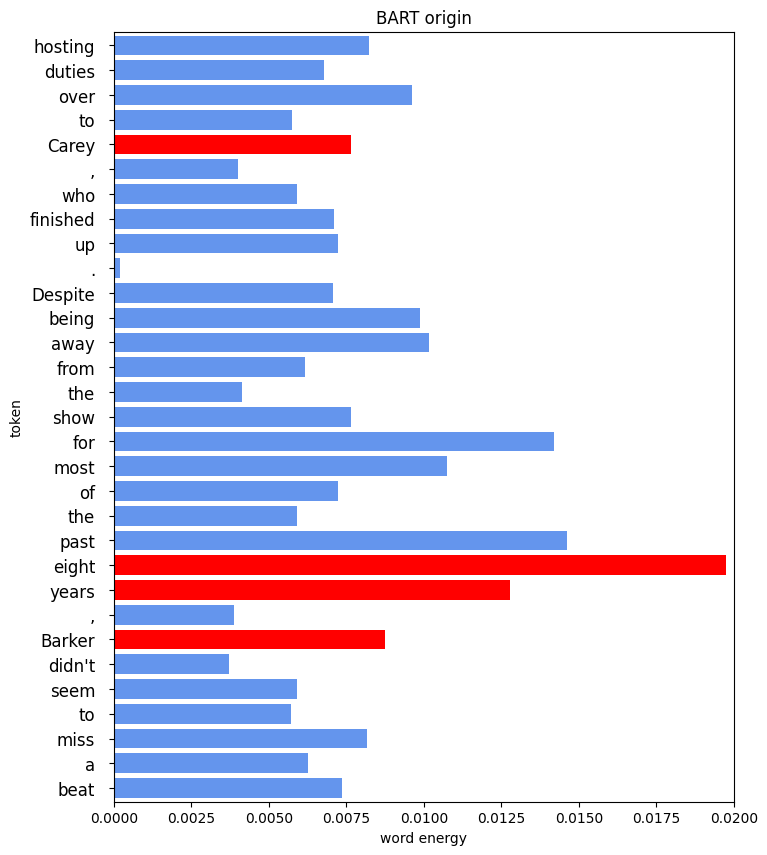

In [104]:
# from matplotlib.ticker import MultipleLocator
# import matplotlib.ticker as ticker
seg_id=0
keyword = tok.decode(batcha['keyword_ids'][0]).split()
# selected = torch.where(torch.tensor(seg)==seg_id, True, False)
# s_w_y = torch.tensor(w_y)[selected].tolist()
# s_w_y = torch.softmax(torch.tensor(w_y) ,dim=-1)[selected].tolist()
# s_w_y = torch.softmax(torch.tensor(w_y)/0.1 ,dim=-1)[selected].tolist() # word energy
# s_w_y = torch.softmax(torch.tensor(w_y)/0.4 ,dim=-1).tolist() # word energy
s_w_y = torch.softmax(torch.tensor(w_y) ,dim=-1).tolist() 
length = int(len(s_w_y)/4)
# s_w_y = s_w_y[:length]
x = 3*length
y = 4*length
s_w_y = s_w_y[x:y]
# s_w_y = torch.softmax(torch.tensor(w_y) ,dim=-1).tolist() # word energy

# seg_word_n = word_n[torch.nonzero(selected).squeeze(-1)[0].item():torch.nonzero(selected).squeeze(-1)[-1].item()+1]
seg_word_n = word_n[x:y]
fig, ax = plt.subplots(figsize=(8, 10))
colors = ['cornflowerblue' if label not in keyword else 'red' for label in seg_word_n[::-1]]
ax.set_xlim(0, 0.02)

y_ticks = np.arange(0,len(seg_word_n),1)

ax.barh(y_ticks, s_w_y[::-1], color=colors)
# ax.barh(seg_word_n[::-1], s_w_y[::-1], color=colors)
# y_ticks = np.arange(0,len(seg_word_n)*2,2)
ax.set_yticks(y_ticks)
ax.set_yticklabels(seg_word_n[::-1])
# ax.set_xticklabels(s_w_y[::-1])

ax.tick_params(axis='y', labelsize=12,pad=10)
# ax.set_ylabel(s_w_y[::-1], fontproperties=font, multialignment='center', labelpad=100)  # 调整labelpad的值
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
# ax.barh(seg_word_n, s_w_y)
# 設定圖表標題和軸標籤
# plt.title('第'+dic_num[str(i+1)]+'句', fontproperties=font)
plt.title('BART origin')
# plt.title('BART adaptive-wordrank')
plt.xlabel('word energy')
plt.ylabel('token')
plt.margins(y=0.005)
# plt.subplots_adjust(top=0.6, bottom=0.4)  # 根据需要调整参数值
# plt.tight_layout()
# plt.savefig("origin_"+str(seg_id)+".png", dpi=300)
# plt.savefig("comparison_"+str(seg_id)+".png", dpi=300)
# 顯示圖表
plt.show()